In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras

tf.random.set_seed(0)

In [2]:
# Feature lists
standard_features = ["DMP_5", "DMP_10", "DMN_5", "DMN_10", "MACD_8_21_5", "AO_5_10",
    "EMA_15", "MA_20", "KAMA_3_2_10", "CO", "C2O2", "C3O3",
    "net_add_ask_size", "net_add_bid_size", "Bollinger_Upper", "Bollinger_Lower"
]

minmax_features = [
    "ADX_10", "ADX_7", "ADX_5", "STOCHk_7_3_3", "STOCHd_7_3_3", "RSI_7", "time_since_open"
]

unscaled_features = ['market_session']
features = standard_features + minmax_features + unscaled_features

In [3]:
sampling_rate = "1s"
prediction_column = ["returns", "returns_volatilities"]
batch_size = 16
epochs = 10
look_back = 32

In [4]:
from tf_preprocessing import process_and_combine_data

start_date = "2024-10-02"
end_date = "2024-10-02"

all_data = process_and_combine_data(start_date, end_date, data_folder="../AAPL_data", sampling_rate=sampling_rate)

print(all_data.columns)

all_data.head()

Index(['trade_ask_size', 'trade_bid_size', 'net_add_ask_size',
       'net_add_bid_size', 'mid_price_high', 'mid_price_low',
       'mid_price_close', 'mid_price_open', 'returns', 'returns_volatility',
       'Returns', 'Target_close', 'ADX_5', 'ADX_7', 'ADX_10', 'DMP_5',
       'DMP_10', 'DMN_5', 'DMN_10', 'AROONU_7', 'AROOND_7', 'OLL3', 'OLL5',
       'OLL10', 'OLL15', 'OHH3', 'OHH5', 'STOCHk_7_3_3', 'STOCHd_7_3_3',
       'MACD_8_21_5', 'RSI_7', 'AO_5_10', 'EMA_15', 'HMA_10', 'KAMA_3_2_10',
       'MA_10', 'MA_20', 'rmCO(3)', 'rmCO(4)', 'rmCO(5)', 'rmCO(6)',
       'Bollinger_Upper', 'Bollinger_Lower', 'U_minus_L', 'MA20dSTD', 'CO',
       'C1O1', 'C2O2', 'C3O3', 'range', 'OH1', 'time_since_open', 'dow_2',
       'market_session'],
      dtype='object')


,trade_ask_size,trade_bid_size,net_add_ask_size,net_add_bid_size,mid_price_high,mid_price_low,mid_price_close,mid_price_open,returns,returns_volatility,...,MA20dSTD,CO,C1O1,C2O2,C3O3,range,OH1,time_since_open,dow_2,market_session
ts_event,,,,,,,,,,,,,,,,,,,,,
2024-10-02 09:30:24-04:00,354.0,4.0,649.0,487.0,225.835,225.78,225.780,225.835,-0.000244,0.000016,...,0.070009,-0.055,-0.010,2.842171e-14,8.500000e-02,0.055,0.000,24.0,1,0
2024-10-02 09:30:25-04:00,150.0,400.0,-1398.0,1150.0,225.890,225.78,225.875,225.780,0.000421,0.000012,...,0.062230,0.095,-0.055,-1.000000e-02,2.842171e-14,0.110,0.000,25.0,1,0
2024-10-02 09:30:26-04:00,824.0,0.0,-477.0,434.0,225.880,225.86,225.870,225.875,-0.000022,0.000011,...,0.064626,-0.005,0.095,-5.500000e-02,-1.000000e-02,0.020,0.110,26.0,1,0
2024-10-02 09:30:27-04:00,0.0,0.0,206.0,42.0,225.880,225.87,225.875,225.870,0.000022,0.000016,...,0.061024,0.005,-0.005,9.500000e-02,-5.500000e-02,0.010,0.005,27.0,1,0
2024-10-02 09:30:28-04:00,849.0,0.0,526.0,389.0,225.875,225.84,225.845,225.875,-0.000133,0.000011,...,0.055731,-0.030,0.005,-5.000000e-03,9.500000e-02,0.035,0.010,28.0,1,0


In [40]:
all_data.Target_close.value_counts()

Target_close
2.0    24848
0.0    23470
1.0    20814
Name: count, dtype: int64

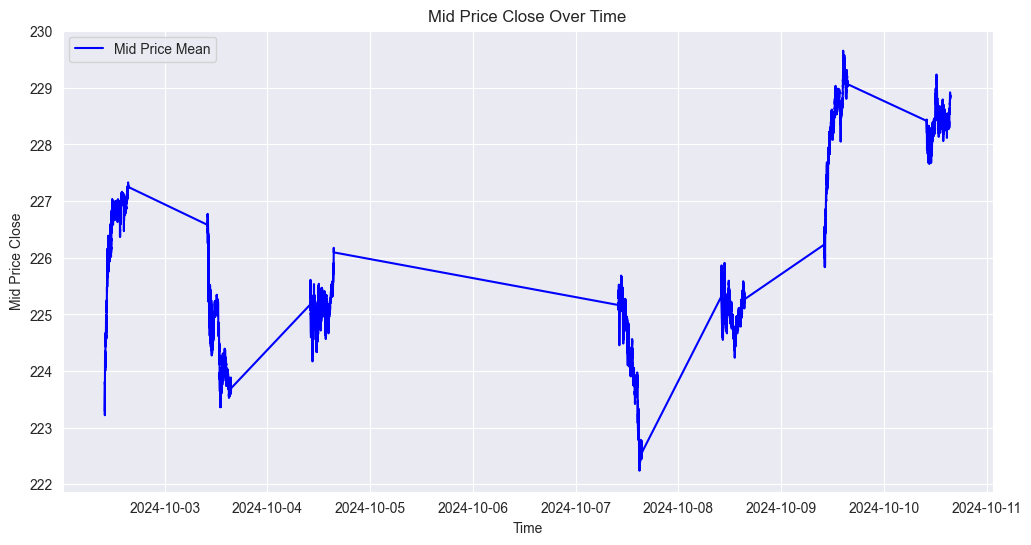

In [41]:
sns.set_style("darkgrid")

plt.figure(figsize=(12, 6))
plt.plot(all_data.index, all_data["mid_price_close"], label="Mid Price Mean", color="blue")
plt.xlabel("Time")
plt.ylabel("Mid Price Close")
plt.title("Mid Price Close Over Time")
plt.legend()
plt.show()

In [42]:
# Data Splitting
train_size = int(len(all_data) * 0.7)
val_size = int(len(all_data) * 0.1)
test_size = len(all_data) - train_size - val_size

train_df = all_data.iloc[:train_size, :]
val_df = all_data.iloc[train_size:train_size + val_size, :]
test_df = all_data.iloc[train_size + val_size:, :]

In [ ]:
from tensorflow.keras.utils import Sequence
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from collections import Counter

standard_indices = [features.index(f) for f in standard_features]
minmax_indices = [features.index(f) for f in minmax_features]
unscaled_indices = [features.index(f) for f in unscaled_features]

class TimeSeriesScalerGenerator(Sequence):
    def __init__(self, data, target, look_back, batch_size=32, oversample=False, **kwargs):
        """
        Custom Timeseries Generator with per-sequence scaling and optional oversampling.
        
        Args:
            data (pd.DataFrame): DataFrame with feature columns.
            target (str): Target column name.
            look_back (int): Number of past time steps per sample.
            batch_size (int): Batch size.
            oversample (bool): Whether to oversample minority classes.
        """
        super().__init__(**kwargs)  # Call the parent class constructor with kwargs

        self.data = data[features].values  # Extract feature matrix
        self.targets = data[target].values.astype(int)  # Extract target labels
        self.look_back = look_back
        self.batch_size = batch_size
        self.indices = np.arange(len(data) - look_back)
        self.true_labels = self._extract_true_labels()

        # Oversample minority classes if enabled
        if oversample:
            self._oversample_minority_classes()

    def __len__(self):
        """Number of batches per epoch."""
        return int(np.ceil(len(self.indices) / self.batch_size))

    def __getitem__(self, idx):
        """Generates one batch of data."""
        batch_indices = self.indices[idx * self.batch_size : (idx + 1) * self.batch_size]

        # Extract sequences efficiently using list slicing
        batch_data = np.array([self.data[i : i + self.look_back] for i in batch_indices])

        # Preallocate arrays for batch
        X_batch = np.empty((len(batch_indices), self.look_back, len(features)), dtype=np.float32)
        y_batch = np.empty((len(batch_indices), self.targets.shape[1]), dtype=np.float32)

        # Scale each sequence individually
        for i, seq in enumerate(batch_data):
            standard_scaler = StandardScaler()
            minmax_scaler = MinMaxScaler(feature_range=(0, 1))

            seq_standard = standard_scaler.fit_transform(seq[:, standard_indices])
            seq_minmax = minmax_scaler.fit_transform(seq[:, minmax_indices])
            seq_unscaled = (
                seq[:, unscaled_indices] 
                if unscaled_features else np.empty((self.look_back, 0))
            )

            X_batch[i] = np.hstack((seq_standard, seq_minmax, seq_unscaled))
            y_batch[i] = self.targets[batch_indices[i] + self.look_back]

        return X_batch, y_batch
    
    def _extract_true_labels(self):
        """Extract all true labels for the entire dataset."""
        return np.array([self.targets[i + self.look_back] for i in self.indices])

    def _oversample_minority_classes(self):
        """Oversample minority classes by duplicating their sequences."""
        # Count class distribution
        class_counts = Counter(self.true_labels)
        max_count = max(class_counts.values())

        # Collect indices for each class
        class_indices = {label: np.where(self.true_labels == label)[0] for label in class_counts}

        # Oversample minority classes
        oversampled_indices = []
        for label, indices in class_indices.items():
            repeat_count = max_count // len(indices)  # Number of times to repeat the minority class
            oversampled_indices.extend(np.repeat(indices, repeat_count))
            oversampled_indices.extend(np.random.choice(indices, max_count % len(indices), replace=True))

        # Update indices and true_labels
        self.indices = np.array(oversampled_indices)
        self.true_labels = self.true_labels[self.indices]



In [ ]:
train_gen = TimeSeriesScalerGenerator(train_df, prediction_columns, look_back, batch_size, oversample=True)
val_gen = TimeSeriesScalerGenerator(val_df, prediction_columns, look_back, batch_size)
test_gen = TimeSeriesScalerGenerator(test_df, prediction_columns, look_back, batch_size)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
from keras import layers, Model, optimizers

input_size = len(features)

inputs = layers.Input(shape=(look_back, input_size))

# First LSTM layer
x = layers.LSTM(128, return_sequences=True)(inputs)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)  # Dropout after LSTM

# Second LSTM layer
x = layers.LSTM(64, return_sequences=False)(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)

# Dense layers
x = layers.Dense(32, activation="relu")(x)
x = layers.Dropout(0.2)(x)

# Two outputs for regression
returns_output = layers.Dense(1, name="returns")(x)  # Output for returns
volatility_output = layers.Dense(1, name="returns_volatilities")(x)  # Output for volatilities

# Create model
model = Model(inputs=inputs, outputs=[returns_output, volatility_output])

optimizer = optimizers.Adam(learning_rate=0.001)

# Compile the model
model.compile(
    optimizer=optimizer, 
    loss={"returns": "mean_squared_error", "returns_volatilities": "mean_squared_error"},
    metrics={"returns": "mae", "returns_volatilities": "mae"}
)

# Train Model
model.fit(train_gen, validation_data=val_gen, epochs=epochs)

Epoch 1/10
3023/3023 ━━━━━━━━━━━━━━━━━━━━ 93s 28ms/step - accuracy: 0.3659 - loss: 1.1836 - val_accuracy: 0.3406 - val_loss: 1.1660
Epoch 2/10
3023/3023 ━━━━━━━━━━━━━━━━━━━━ 85s 28ms/step - accuracy: 0.3987 - loss: 1.0854 - val_accuracy: 0.3489 - val_loss: 1.1587
Epoch 3/10
3023/3023 ━━━━━━━━━━━━━━━━━━━━ 91s 30ms/step - accuracy: 0.3987 - loss: 1.0835 - val_accuracy: 0.3552 - val_loss: 1.1018
Epoch 4/10
3023/3023 ━━━━━━━━━━━━━━━━━━━━ 92s 30ms/step - accuracy: 0.3865 - loss: 1.0883 - val_accuracy: 0.3495 - val_loss: 1.1184
Epoch 5/10
3023/3023 ━━━━━━━━━━━━━━━━━━━━ 88s 29ms/step - accuracy: 0.3881 - loss: 1.0857 - val_accuracy: 0.3550 - val_loss: 1.1101
Epoch 6/10
3023/3023 ━━━━━━━━━━━━━━━━━━━━ 89s 29ms/step - accuracy: 0.3917 - loss: 1.0840 - val_accuracy: 0.3552 - val_loss: 1.1151
Epoch 7/10
3023/3023 ━━━━━━━━━━━━━━━━━━━━ 113s 37ms/step - accuracy: 0.3767 - loss: 1.0893 - val_accuracy: 0.3404 - val_loss: 1.1152
Epoch 8/10
3023/3023 ━━━━━━━━━━━━━━━━━━━━ 122s 40ms/step - accuracy: 0.3759

In [ ]:
# Evaluate the model
test_results = model.evaluate(test_gen)
print("Test Loss (Returns):", test_results[1])
print("Test MAE (Returns):", test_results[3])

print("Test Loss (Volatilities):", test_results[2])
print("Test MAE (Volatilities):", test_results[4])